In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
INPUT_FILE = '../dataset/flipkart_products_preprocessed_1.csv'

In [3]:
df = pd.read_csv(INPUT_FILE)

## Structural EDA

In [4]:
df.shape

(508525, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508525 entries, 0 to 508524
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       508525 non-null  int64  
 1   url              508525 non-null  object 
 2   title            508525 non-null  object 
 3   price            508525 non-null  float64
 4   discount         508525 non-null  float64
 5   rating_value     474497 non-null  float64
 6   hierarchy        508525 non-null  object 
 7   description      508525 non-null  object 
 8   hierarchy_list   508525 non-null  object 
 9   hierarchy_depth  508525 non-null  int64  
 10  level_1          508525 non-null  object 
 11  level_2          503849 non-null  object 
 12  level_3          503849 non-null  object 
 13  level_4          503651 non-null  object 
 14  level_5          498130 non-null  object 
 15  level_6          486644 non-null  object 
 16  level_7          327815 non-null  obje

In [6]:
df = df.drop(columns="Unnamed: 0")

In [7]:
df.isna().sum()

url                     0
title                   0
price                   0
discount                0
rating_value        34028
hierarchy               0
description             0
hierarchy_list          0
hierarchy_depth         0
level_1                 0
level_2              4676
level_3              4676
level_4              4874
level_5             10395
level_6             21881
level_7            180710
level_8            506208
dtype: int64

* Category levels level_2 to level_5 are mostly complete.
* Deep levels (level_6, level_7, level_8) have high missingness.

In [8]:
df.describe()

,price,discount,rating_value,hierarchy_depth
count,508525.000000,508525.000000,474497.000000,508525.000000
mean,1261.916574,63.958069,3.736589,6.557750
std,2762.484545,16.339667,0.459571,0.804129
min,25.000000,1.000000,1.000000,1.000000
25%,599.000000,57.000000,3.500000,6.000000
50%,799.000000,68.000000,3.800000,7.000000
75%,1099.000000,75.000000,4.000000,7.000000
max,287774.000000,100.000000,5.000000,8.000000


* Dataset contains a few very high-end products inflating the average.
* Discounts are generally high.
* Most ratings fall between 3.5 and 4, showing limited variability.
* Most products have 6–7 category levels, indicating very detailed taxonomy.

In [9]:
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols].describe()

,url,title,hierarchy,description,hierarchy_list,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8
count,508525,508525,508525,508525,508525,508525,503849,503849,503651,498130,486644,327815,2317
unique,508525,354861,358013,165591,358013,2,43,1928,11519,47063,171357,193206,2127
top,https://www.flipkart.com/homestic-4-5-l-plasti...,SY GiftsBoys Maroon Artificial Leather Wallet(...,Unknown,No Description,['Unknown'],Home,Mobiles & Accessories,Mobile Accessories,Cases & Covers,Designer Cases & Covers,Snooky Mobile Skin Stickers,EthnicBasket Women Printed Straight Kurta (Mul...,Men Solid Casual Pink Shirt
freq,1,452,4676,79283,4676,503849,268434,268289,217987,191325,6300,415,6


* Unique values increase with each level - clear multi-level hierarchy complexity.
* Deepest category levels are sparsely populated and should not be used for modeling.

## Numerical Feature Analysis

<Axes: xlabel='price', ylabel='Count'>

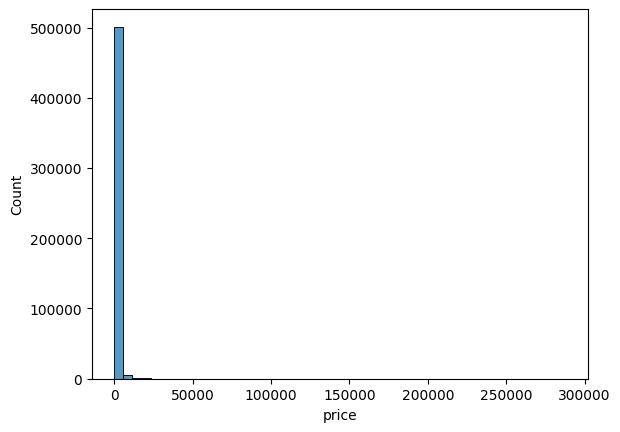

In [10]:
sns.histplot(df['price'], bins=50)

* The huge spike near ₹0–₹2,000 shows that most products are low to mid-priced.

<Axes: xlabel='discount', ylabel='Count'>

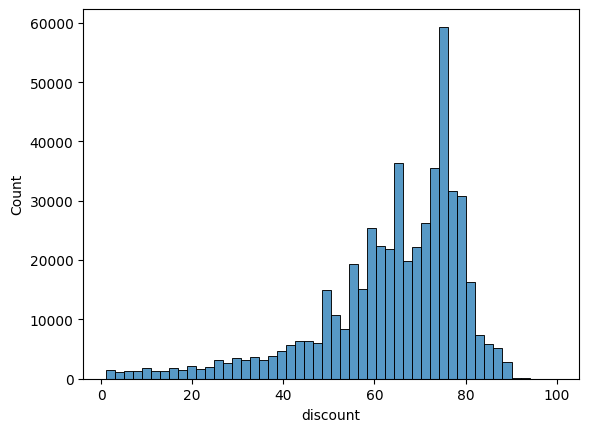

In [11]:
sns.histplot(df['discount'], bins=50)

* Flipkart’s pricing strategy favors high visible discounts; pricing appears heavily “inflated MRP + large discount”, common in e-commerce.

<Axes: xlabel='rating_value', ylabel='Count'>

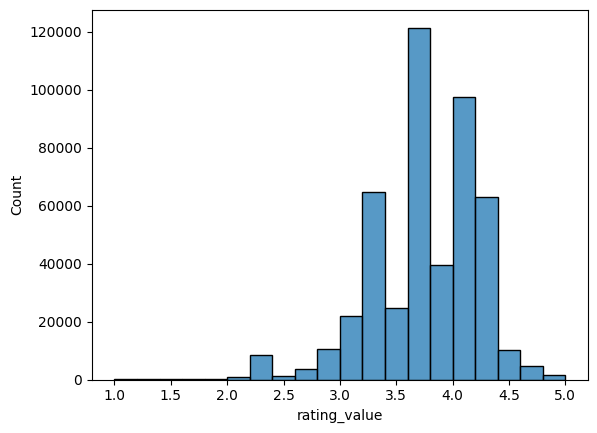

In [12]:
sns.histplot(df['rating_value'], bins=20)

* Ratings vary only slightly across products, meaning rating_value is not a strong differentiator and may have limited predictive power for discount.

<Axes: xlabel='hierarchy_depth', ylabel='Count'>

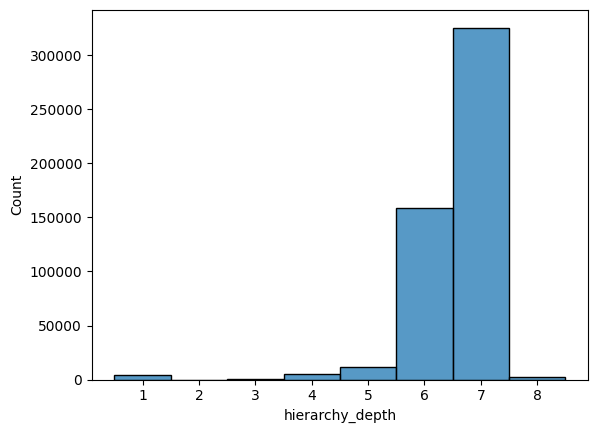

In [13]:
sns.histplot(df['hierarchy_depth'], discrete=True)

* Majority of products have deep category hierarchies
* Depth 8 is extremely rare

<Axes: xlabel='price', ylabel='discount'>

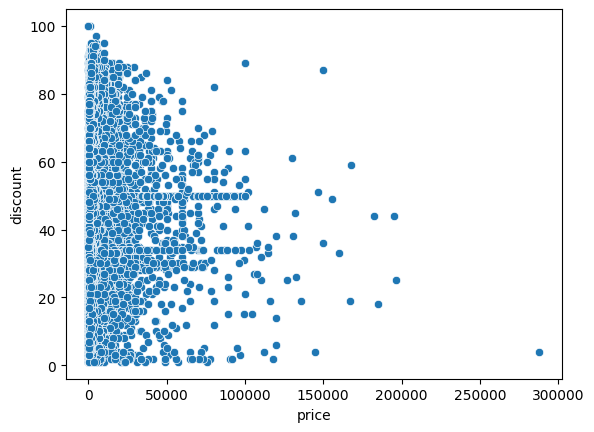

In [14]:
sns.scatterplot(x="price", y="discount", data=df)

* Most products fall under ₹2,000–₹10,000, causing:
    * dense cloud on the left
    * sparse distribution on the right
* Cheapest items get 0% to 100% discounts
    * Wide variation regardless of price
* Discount values cluster around 40%, 50%, 60%, 70%
* Products priced ₹100,000+ are:
    * rare
    * inconsistently discounted
    * spread from 0% to 90%

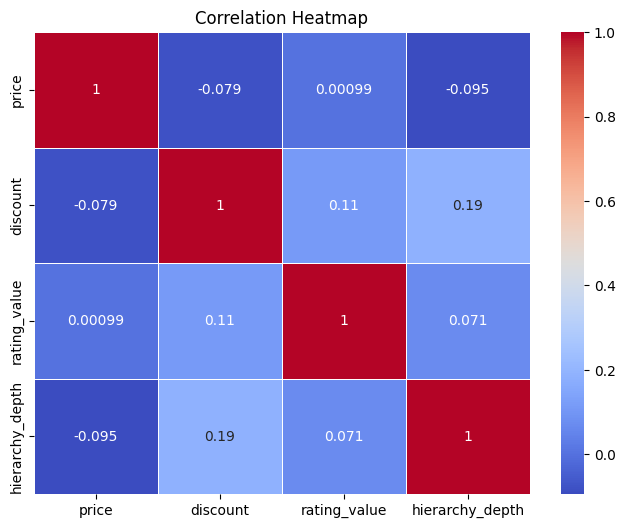

In [15]:
num_cols = ["price", "discount", "rating_value", "hierarchy_depth"]

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

* price and discount: Higher-priced products do NOT consistently get higher or lower discounts.
* rating_value and discount: Products with higher discounts tend to have slightly higher ratings.
* hierarchy_depth and discount: Products with deeper categories (depth 6–7) tend to get slightly higher discounts.

## Categorical Feature Analysis

In [16]:
import matplotlib.pyplot as plt
import math

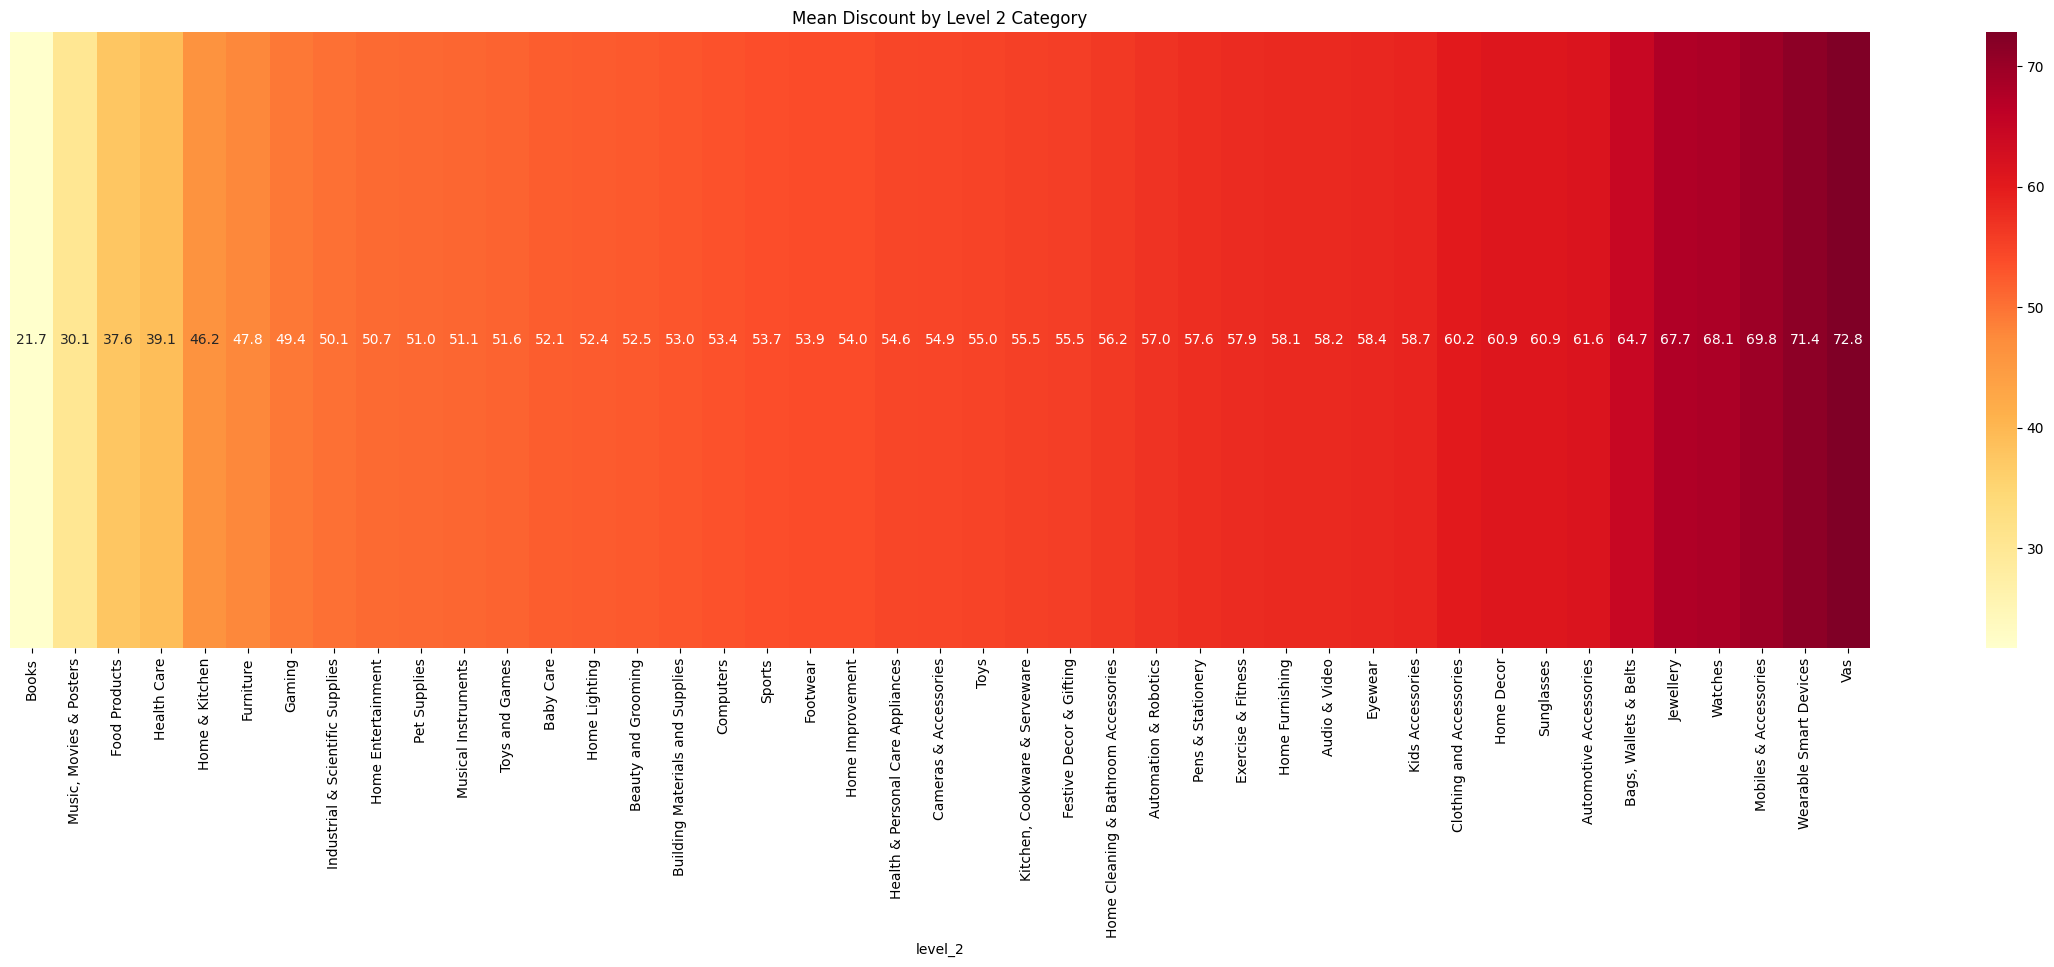

In [17]:
plt.figure(figsize=(30, 8))
level2_discount = df.groupby("level_2")["discount"].mean().sort_values()

sns.heatmap(level2_discount.to_frame().T, 
            cmap="YlOrRd", 
            annot=True, 
            fmt=".1f")
plt.title("Mean Discount by Level 2 Category")
plt.yticks([])
plt.show()

* Books and media categories have the lowest discounts (~22–30%), indicating fixed-price or low-margin products.
* Most household and utility categories lie in the mid-range (50–57% discounts), showing standard competitive pricing.
* Fashion and lifestyle categories show higher discounts (~58–65%), reflecting strong promotional strategies.
* Jewellery, watches, and accessories exceed 67% average discounts, marking them as highly discount-driven markets.
* Mobile accessories and wearable devices top the list with ~70–73% discounts, proving aggressive price-cutting in electronics accessories.

In [18]:
bins = [0, 500, 1000, 2000, 5000, 10000, df["price"].max()]
labels = ["0–500", "500–1k", "1k–2k", "2k–5k", "5k–10k", "10k+"]

In [19]:
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels, include_lowest=True)

In [20]:
result = (
    df.groupby(["level_2", "price_bin"])["discount"]
      .mean()
      .reset_index()
      .sort_values(["level_2", "price_bin"])
)

/var/folders/7p/_l5kmmts4m3886n2ycnm87380000gn/T/ipykernel_6577/132306428.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["level_2", "price_bin"])["discount"]


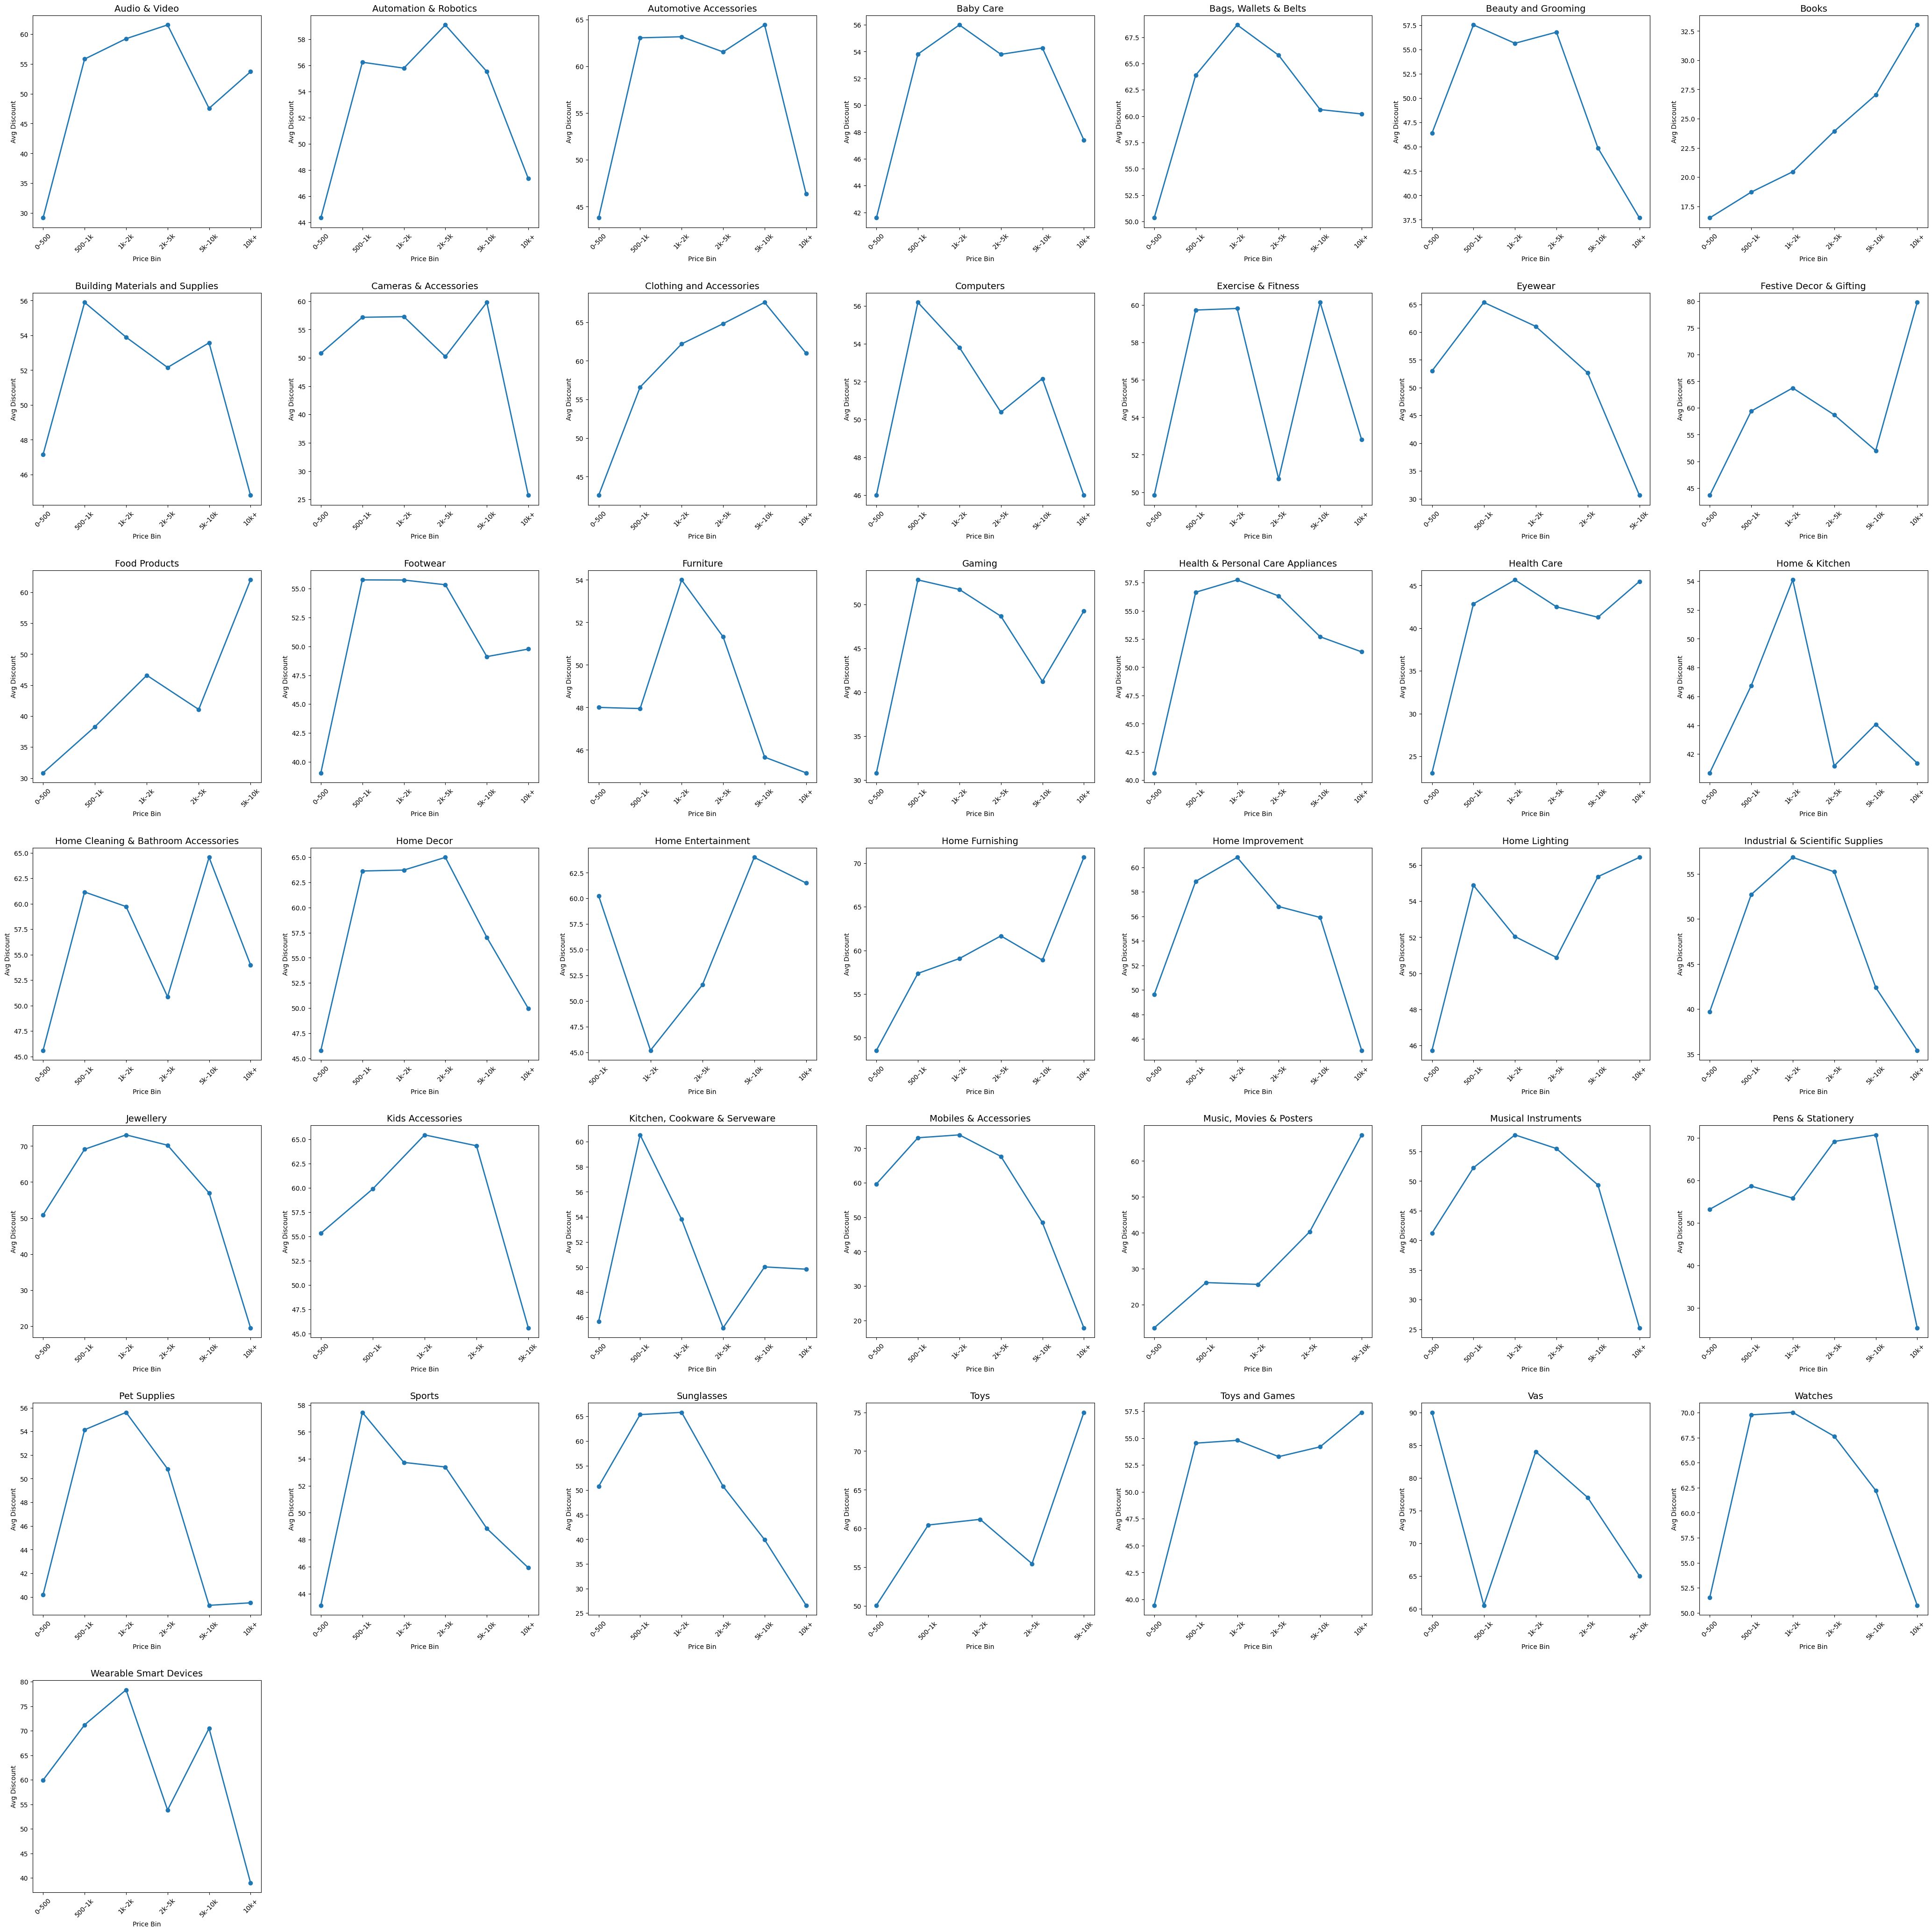

In [21]:
result["price_bin"] = result["price_bin"].astype(str)

levels = result["level_2"].unique()
n = len(levels)

rows, cols = 7, 7

fig, axes = plt.subplots(rows, cols, figsize=(42, 42))
axes = axes.flatten()

for ax, lvl in zip(axes, levels):
    sub = result[result["level_2"] == lvl]

    ax.plot(
        sub["price_bin"],
        sub["discount"],
        marker="o",
        linewidth=2,
        label=lvl
    )

    ax.set_title(f"{lvl}", fontsize=14)
    ax.set_xlabel("Price Bin")
    ax.set_ylabel("Avg Discount")
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="y")

    # ax.legend(loc="upper right", frameon=False)

for i in range(len(levels), len(axes)):
    axes[i].axis("off")

plt.tight_layout(pad=3.0)
plt.show()

* Most categories show highest discounts in mid-range price bins rather than very cheap or very expensive items.
* Low-priced products consistently have the smallest discounts due to tight margins.
* High-priced items see reduced discounts, suggesting premium positioning or margin protection.
* Fashion and lifestyle categories display strong discount volatility, indicating seasonal and promotional cycles.
* Essential goods like books, groceries, and office supplies maintain stable, lower-variance discount patterns.

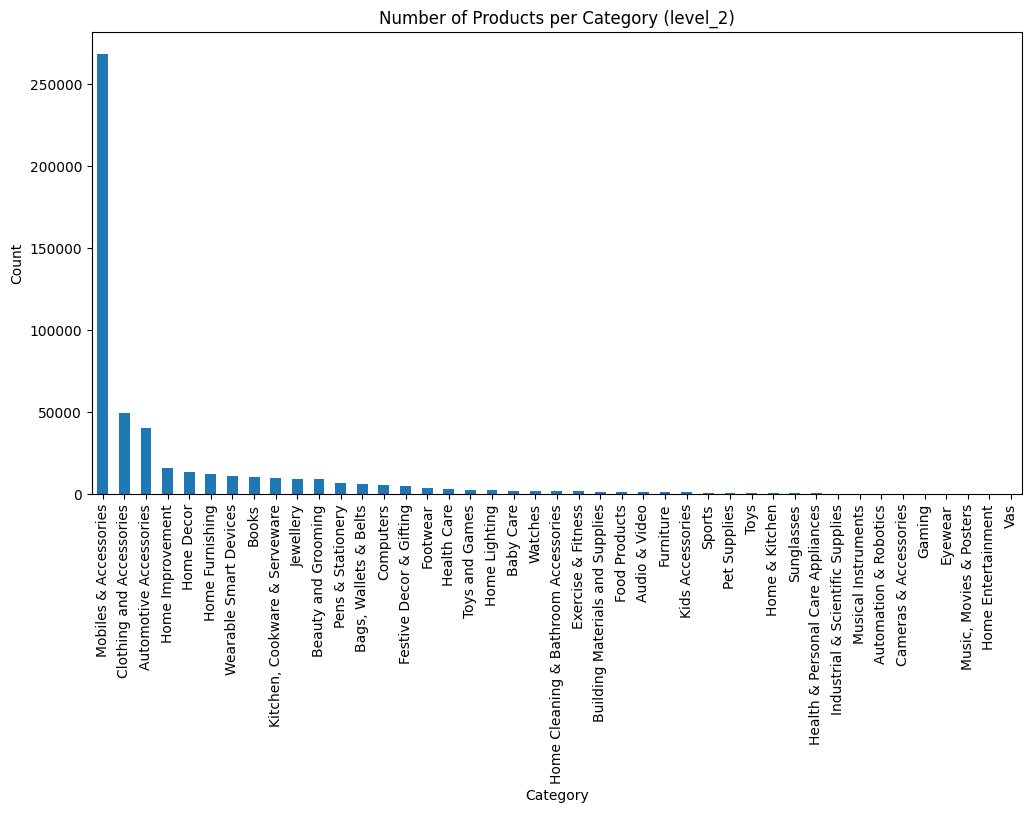

In [22]:
df["level_2"].value_counts().plot(kind="bar", figsize=(12,6))
plt.title("Number of Products per Category (level_2)")
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

* Mobiles & Accessories massively dominate (over 250,000 products), while most other categories have fewer than 10,000.
* This imbalance will hurt analysis, modeling, and clustering unless handled.

## Textual Analysis

In [23]:
from wordcloud import WordCloud, STOPWORDS

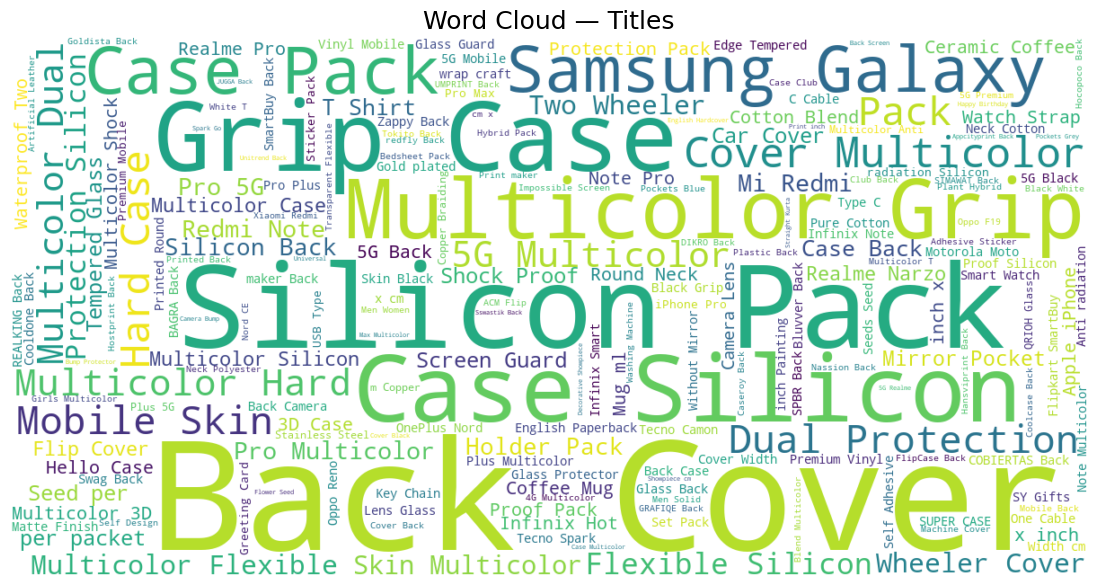

In [24]:
text_titles = " ".join(df["title"].dropna().astype(str).tolist())

wc_title = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
).generate(text_titles)

plt.figure(figsize=(14, 7))
plt.imshow(wc_title, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Titles", fontsize=18)
plt.show()

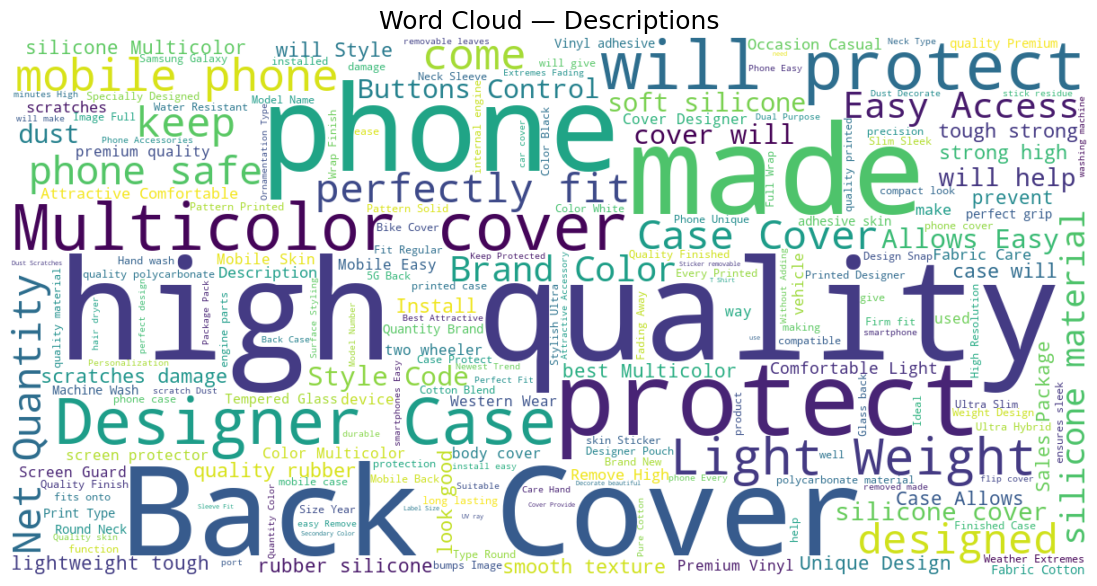

In [25]:
text_titles = " ".join(df["description"].dropna().astype(str).tolist())

wc_title = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
).generate(text_titles)

plt.figure(figsize=(14, 7))
plt.imshow(wc_title, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Descriptions", fontsize=18)
plt.show()

In [26]:
df["title_len"] = df["title"].astype(str).str.len()

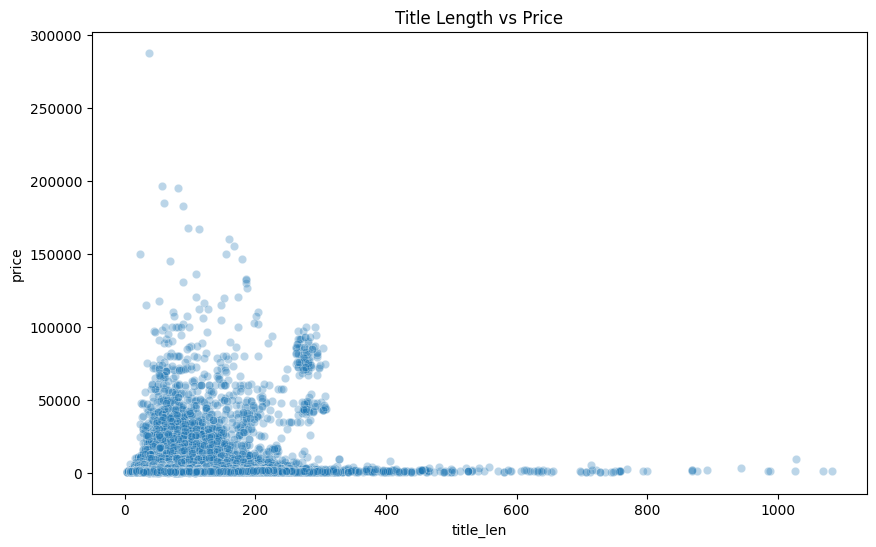

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="title_len", y="price", alpha=0.3)
plt.title("Title Length vs Price")
plt.show()

* Title length has no noticeable correlation with price — the scatter is widely dispersed.
* Most products use short titles (below ~150 characters), forming a dense cluster.
* Very long titles (300–1000+ characters) mostly correspond to low-priced items, indicating keyword stuffing.
* High-priced items only appear with short to medium-length titles, never with extremely long ones.
* The price distribution is heavily skewed toward low and mid-range products, regardless of title length.

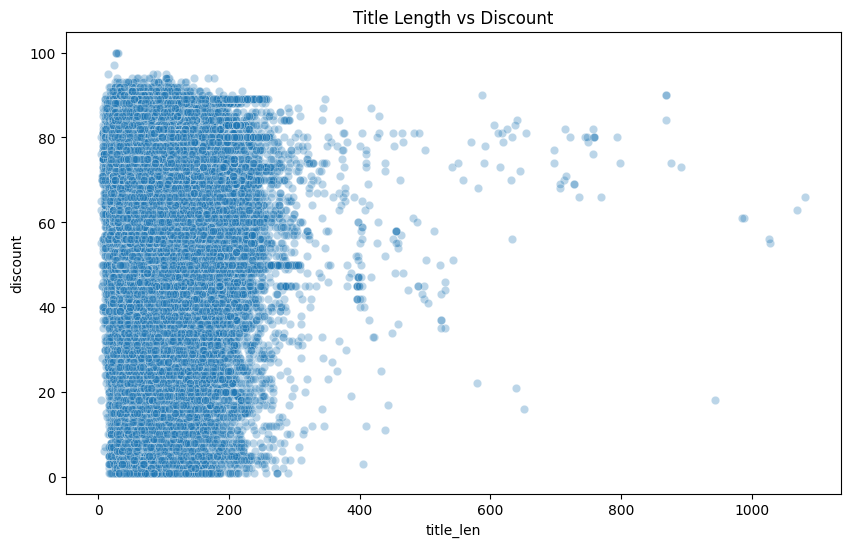

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="title_len", y="discount", alpha=0.3)
plt.title("Title Length vs Discount")
plt.show()


* No clear correlation exists between title length and discount — discounts appear across all title lengths.
* Most products with very short to medium titles (0–200 chars) receive the full range of discounts, from 0% to 100%.
* Extremely long titles (400–1000+ chars) tend to cluster around medium-to-high discounts, suggesting many are promotional or keyword-stuffed listings.
* High-discount items are not associated with any specific title length, indicating discounting depends on category/merchant strategy rather than title structure.
* The plot is dominated by shorter titles, reflecting typical e-commerce writing patterns, with longer titles being rare outliers.

In [29]:
df["desc_len"]  = df["description"].astype(str).str.len()

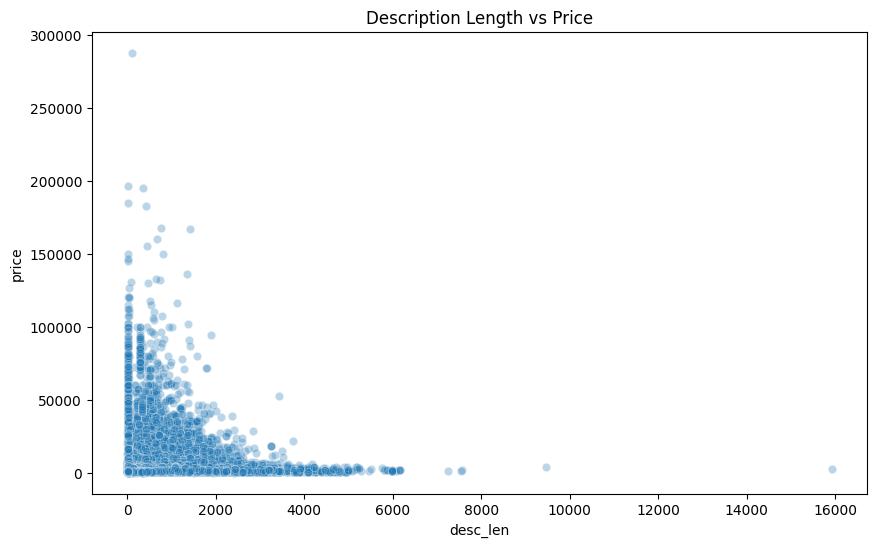

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="desc_len", y="price", alpha=0.3)
plt.title("Description Length vs Price")
plt.show()

* Most products have short descriptions (under ~1500 characters), forming a dense cluster on the left side.
* Higher-priced items appear mostly in the short-to-medium description range, suggesting premium products don’t rely on very long text.
* Extremely long descriptions (5000–16000+ chars) almost always belong to low-priced items, likely due to keyword stuffing or bulk-listed items.
* There is no strong positive correlation between description length and price, meaning long text doesn’t indicate a higher value item.
* Price distribution is heavily skewed toward low and mid-range items regardless of description length, similar to your title-length result.

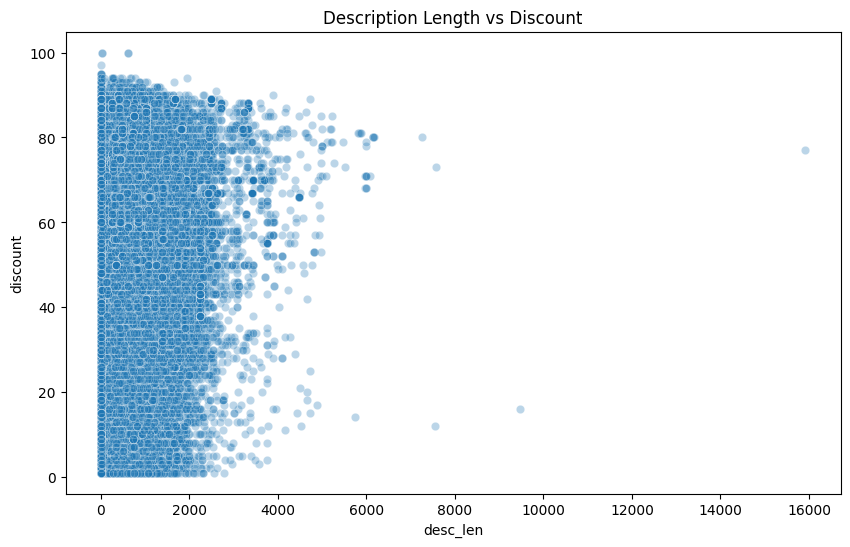

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="desc_len", y="discount", alpha=0.3)
plt.title("Description Length vs Discount")
plt.show()

* Discounts are spread across all description lengths, showing no strong correlation between how long a description is and the discount offered.
* Most discounts occur in products with short to medium descriptions (0–2000 characters), where the plot is densely populated.
* Very long descriptions (4000–16000+ characters) tend to have medium-to-high discounts, suggesting these listings may be promotional or keyword-heavy.
* Short descriptions also include the full range of discounts (0–100%), indicating merchants’ discounting strategies are independent of description detail.
* The heavy vertical clustering near lower character counts shows that most sellers use brief descriptions, regardless of the discount level.